# Ensemble with Random Forrest, GBC and XGB

In [2]:
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from scipy.sparse import hstack

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
df = pd.read_csv('/kaggle/input/hate-speech-detection-curated-dataset/HateSpeechDatasetBalanced.csv')  # replace with your file path
df['clean_text'] = df['Content'].apply(clean_text)  # 'text' column contains raw tweets

In [5]:
tfidf = TfidfVectorizer(max_features=3000)
tfidf_features = tfidf.fit_transform(df['clean_text'])

In [6]:
df['text_len'] = df['clean_text'].apply(lambda x: len(x.split()))
nlp_features = df[['text_len']].values

In [7]:
from scipy.sparse import csr_matrix
combined_features = hstack([tfidf_features, csr_matrix(nlp_features)])

In [19]:
X_train, X_test, y_train, y_test = train_test_split(combined_features, df['Label'], test_size=0.2, random_state=42)

clf1 = RandomForestClassifier(n_estimators=50, n_jobs=-1)
print("In RF")
clf1.fit(X_train, y_train)
clf2 = GradientBoostingClassifier(n_estimators=50, random_state=1, verbose=1)
print("In GBC")
clf2.fit(X_train, y_train)
clf3 = XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=1)
print("In XGB")
clf3.fit(X_train, y_train)

ensemble = VotingClassifier(estimators=[
    ('rf', clf1), 
    ('gb', clf2), 
    ('xgb', clf3)
], voting='soft')

ensemble.fit(X_train, y_train)

In XGB
      Iter       Train Loss   Remaining Time 
         1           1.3663            4.56m
         2           1.3496            4.37m
         3           1.3357            4.25m
         4           1.3234            4.15m
         5           1.3128            4.05m
         6           1.3032            3.97m
         7           1.2944            3.88m
         8           1.2867            3.78m
         9           1.2788            3.69m
        10           1.2720            3.60m
        20           1.2251            2.70m
        30           1.1953            1.80m
        40           1.1737           54.09s
        50           1.1560            0.00s


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(n_estimators=50,
                                                     n_jobs=-1)),
                             ('gb',
                              GradientBoostingClassifier(n_estimators=50,
                                                         random_state=1,
                                                         verbose=1)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorica...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))],
                 voting='soft')

In [20]:
y_pred = ensemble.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.80      0.83     72043
           1       0.81      0.87      0.84     73181

    accuracy                           0.84    145224
   macro avg       0.84      0.83      0.83    145224
weighted avg       0.84      0.84      0.83    145224



# Confusion Matrix for THE ENSEMBLE

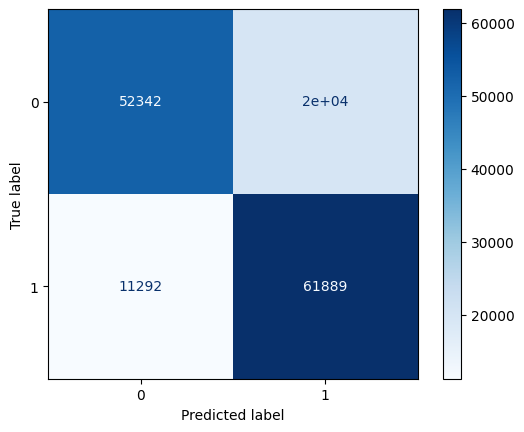

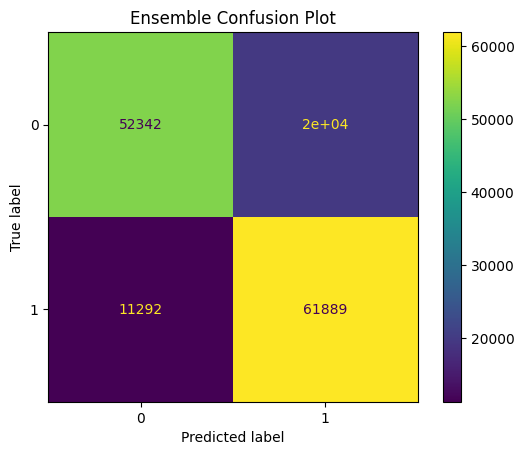

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=ensemble.classes_)
disp = ConfusionMatrixDisplay.from_predictions(y_test,y_pred,
                              display_labels=ensemble.classes_,
                            cmap=plt.cm.Blues)
disp.plot()
plt.title("Ensemble Confusion Plot")
plt.show()

# Confusion matrix for RF

              precision    recall  f1-score   support

           0       0.87      0.82      0.84     72043
           1       0.83      0.88      0.85     73181

    accuracy                           0.85    145224
   macro avg       0.85      0.85      0.85    145224
weighted avg       0.85      0.85      0.85    145224



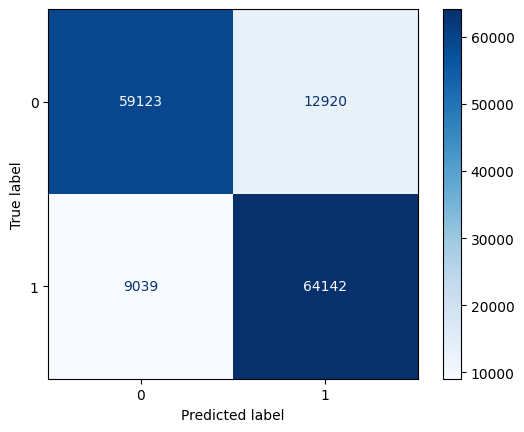

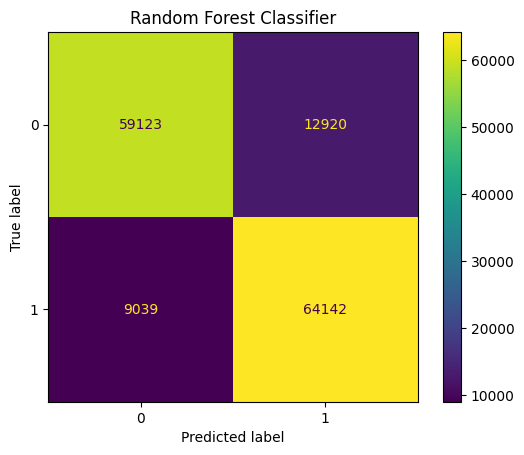

In [40]:
y_pred = clf1.predict(X_test)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, labels=clf1.classes_)
disp = ConfusionMatrixDisplay.from_predictions(y_test,y_pred,
                                                display_labels=clf1.classes_,
                                                cmap=plt.cm.Blues    
                                              )
disp.plot()
plt.title("Random Forest Classifier")
plt.show()

              precision    recall  f1-score   support

           0       0.83      0.49      0.62     72043
           1       0.64      0.90      0.75     73181

    accuracy                           0.70    145224
   macro avg       0.74      0.70      0.68    145224
weighted avg       0.73      0.70      0.68    145224



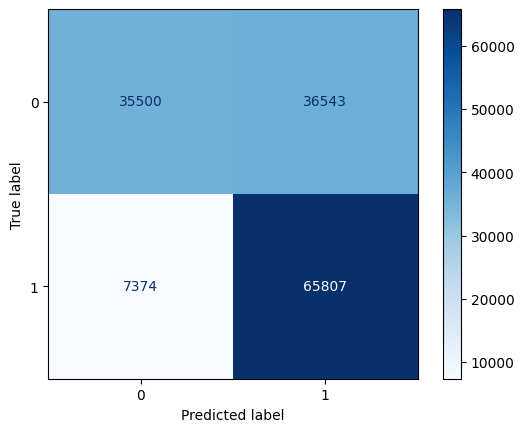

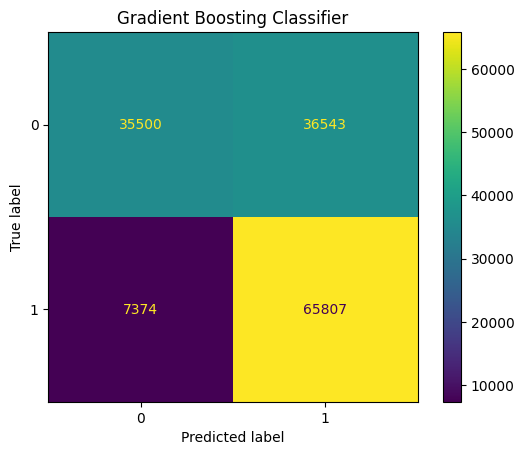

In [41]:
y_pred = clf2.predict(X_test)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, labels=clf2.classes_)
disp = ConfusionMatrixDisplay.from_predictions(y_test,y_pred,
                              display_labels=clf2.classes_,
                            cmap=plt.cm.Blues   
                            )
disp.plot()
plt.title("Gradient Boosting Classifier")
plt.show()

              precision    recall  f1-score   support

           0       0.82      0.73      0.77     72043
           1       0.76      0.85      0.80     73181

    accuracy                           0.79    145224
   macro avg       0.79      0.79      0.79    145224
weighted avg       0.79      0.79      0.79    145224



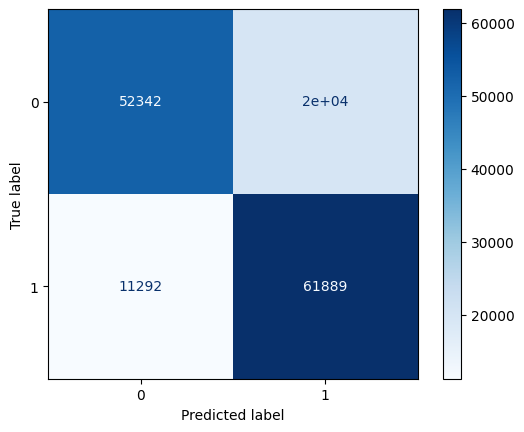

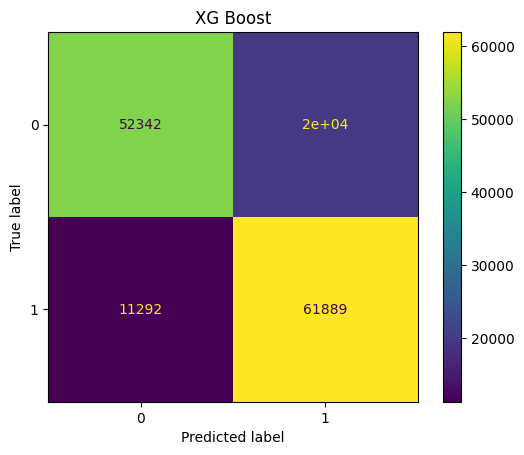

In [43]:
y_pred = clf3.predict(X_test)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, labels=clf3.classes_)
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, 
                              display_labels=clf3.classes_,
                             cmap=plt.cm.Blues   )
disp.plot()
plt.title("XG Boost")
plt.show()

In [21]:
import pickle
with open('rf.pkl',"wb") as file:
    pickle.dump(clf1,file)

with open('gbc.pkl','wb') as file:
    pickle.dump(clf2,file)

with open('xgb.pkl','wb') as file:
    pickle.dump(clf3,file)

In [18]:
'''clf1 = pickle.load(open('rf.pkl','rb'))
clf2 = pickle.load(open('gbc.pkl','rb'))
clf3 = pickle.load(open('xgb.pkl','rb'))'''

In [22]:
with open('ensemble_rgx.pkl','wb') as file:
    pickle.dump(ensemble,file)